In [3]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.13.0+cu116
0.14.0+cu116


In [4]:
try:
  import torchinfo
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Get Data

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## visualize the data

In [6]:
import random
import matplotlib.pyplot  as plt
from PIL import Image

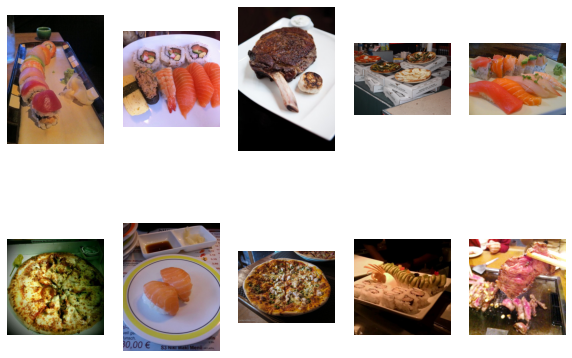

In [7]:
img_list=image_path.glob("*/*/*.jpg")
plt.figure(figsize=(10, 7))
rand_img=random.sample(list(img_list),10)
for i,path in enumerate(rand_img):
  img=Image.open(path)
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.axis(False);

## data loader

In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

###  Creating a transform for `torchvision.models` (manual creation)

> **Note:** As of `torchvision` v0.13+, there's an update to how data transforms can be created using `torchvision.models`. I've called the previous method "manual creation" and the new method "auto creation". This notebook showcases both.

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of: 

| **Transform number** | **Transform required** | **Code to perform transform** | 
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  | 

> **Note:** ^some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [9]:
from torchvision import transforms

data_transforms=transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),

                                  ])

In [10]:
data_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [11]:
from torchvision import datasets


train_data= datasets.ImageFolder(root=train_dir,
                                 transform=data_transforms,
                                 target_transform=None)
test_data= datasets.ImageFolder(root=test_dir,
                                transform=data_transforms)

print(train_data,test_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [12]:
class_names=train_data.classes

In [13]:
class_idx=train_data.class_to_idx

In [14]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

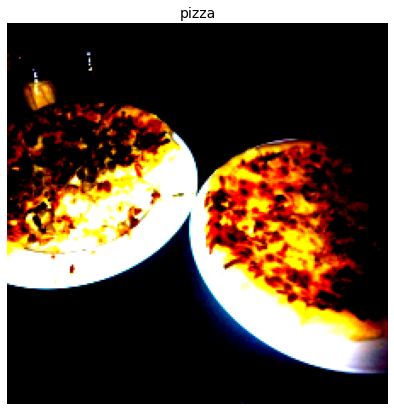

In [15]:
plt.figure(figsize=(10,7))
plt.imshow(next(iter(train_data))[0].permute(1,2,0).detach().cpu().numpy())
plt.title(f"{class_names[(next(iter(train_data))[1])]}",fontsize=14)
plt.axis("off");

In [16]:
from torch.utils.data.dataloader import DataLoader
import os
train_dataloader=DataLoader(train_data,
                            batch_size=1,
                            shuffle=True,
                            num_workers=os.cpu_count())
test_dataloader=DataLoader(test_data,
                            batch_size=1,
                            shuffle=True,
                            num_workers=os.cpu_count())
print(train_dataloader),print(test_dataloader)

(None, None)

### Creating a transform for `torchvision.models` (auto creation)

As previously stated, when using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Above we saw how to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many differnt model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.
    
Let's try it out.

In [17]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [18]:
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [19]:
from torchvision import datasets
from torch.utils.data.dataloader import DataLoader
from typing import List,Tuple
import os

def load_image(train_dir:str,
               test_dir:str,
               transform:List[str]):
  train_data= datasets.ImageFolder(root=train_dir,
                                  transform=transform,
                                  target_transform=None)
  test_data= datasets.ImageFolder(root=test_dir,
                                  transform=transform)

  return train_data,test_data

def data_loader(train_data:torchvision.datasets.ImageFolder,
                test_data:torchvision.datasets.ImageFolder,
                batch_size:int):
  train_dataloader=DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count())
  test_dataloader=DataLoader(dataset=test_data,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=os.cpu_count())
  return train_dataloader,test_dataloader

In [20]:
train_data,test_data=load_image(train_dir=train_dir,test_dir=test_dir,transform=auto_transforms)
print(train_data,test_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           ) Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )


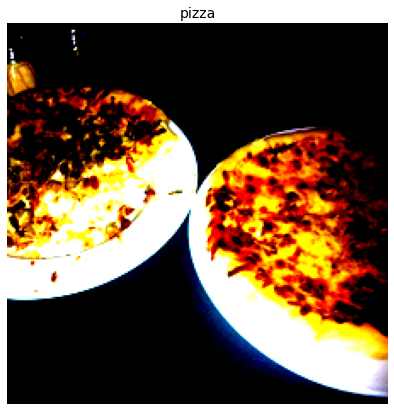

In [21]:
plt.figure(figsize=(10,7))
plt.imshow(next(iter(train_data))[0].permute(1,2,0).detach().cpu().numpy())
plt.title(f"{class_names[(next(iter(train_data))[1])]}",fontsize=14)
plt.axis("off");

In [22]:
train_dataloader,test_dataloader=data_loader(train_data=train_data,test_data=test_data,batch_size=32)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f14f3354700>,
 <torch.utils.data.dataloader.DataLoader at 0x7f14f32f79d0>)

In [23]:
weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [24]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

> **Note:** In previous versions of `torchvision`, you'd create a prertained model with code like:
>
> `model = torchvision.models.efficientnet_b0(pretrained=True).to(device)`
>
> However, running this using `torchvision` v0.13+ will result in errors such as the following:
> 
> `UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.`
>
> And...
> 
> `UserWarning: Arguments other than a weight enum or None for weights are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing weights=EfficientNet_B0_Weights.IMAGENET1K_V1. You can also use weights=EfficientNet_B0_Weights.DEFAULT to get the most up-to-date weights.`

In [25]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params","kernel_size", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  [3, 3]               True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   --                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112,

In [26]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet. 

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

> **Note:** [Dropout layers](https://developers.google.com/machine-learning/glossary#dropout_regularization) randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are *more general*). 

And we'll keep `in_features=1280` for our `Linear` output layer but we'll change the `out_features` value to the length of our `class_names` (`len(['pizza', 'steak', 'sushi']) = 3`).

Our new `classifier` layer should be on the same device as our `model`. 

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [29]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params","kernel_size", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                [3, 3]               False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 --                   False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 3

## train our new model

In [30]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
loss=torch.nn.CrossEntropyLoss()

In [31]:
len(train_dataloader)

8

In [32]:
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

def train_step(traindata_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               loss_fn:torch.nn.Module,
               device=device) -> Tuple[float,float] :
    train_loss,train_acc=0,0
    model.train()
    for batch,(x,y) in enumerate(traindata_loader):
      x=x.to(device)
      y=y.to(device)
      y_logits=model(x)
      loss=loss_fn(y_logits,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_acc+=torch.eq(y_logits.softmax(axis=1).argmax(axis=1),y).sum().item()/len(y)
      train_loss+=loss.item()
    train_acc/=len(traindata_loader)
    train_loss/=len(traindata_loader)
    
    return train_acc,train_loss

def test_step(testdata_loader:torch.utils.data.DataLoader,
              model:torch.nn.Module,
              loss_fn:torch.nn.Module,
              device=device) -> Tuple[float,float]:
      
      model.eval()
      test_acc,test_loss=0,0
      with torch.inference_mode():
        for batch,(x,y) in enumerate(testdata_loader):
          x=x.to(device)
          y=y.to(device)
          y_logits=model(x)
          loss=loss_fn(y_logits,y)
          test_loss+=loss.item()
          test_acc+=torch.eq(y_logits.softmax(axis=1).argmax(axis=1),y).sum().item()/len(y)
        test_acc/=len(testdata_loader)
        test_loss/=len(testdata_loader)

      
      return test_acc,test_loss


def train(model:torch.nn.Module,
          traindata_loader:torch.utils.data.DataLoader,
          testdata_loader:torch.utils.data.DataLoader,
          loss_fn,
          oprimizer:torch.optim.Optimizer,
          device=device,
          epochs=5):
  result={
      "train_acc":[],
      "train_loss":[],
      "test_acc":[],
      "test_loss":[],
      "epoch":[]
  }
  for epoch in tqdm(range(epochs),desc=f"[INFO] Model training started for {epochs} Epochs"):

    train_acc,train_loss=train_step(traindata_loader=traindata_loader,
                        model=model,
                        optimizer=optimizer,
                        loss_fn=loss_fn)
    
    test_acc,test_loss=test_step(testdata_loader=testdata_loader,
                        model=model,
                        loss_fn=loss_fn)
    

    print(f"Epoch : {epoch+1} | Train_loss : {train_loss} | Train_acc : {train_acc} | Test_loss : {test_loss} | Test_acc : {test_acc}")
    

    result["train_acc"].append(train_acc)
    result["train_loss"].append(train_loss)
    result["test_acc"].append(test_acc)
    result["test_loss"].append(test_loss)
    result["epoch"].append(epoch+1)

  return result



result=train(model=model,
          traindata_loader=train_dataloader,
          testdata_loader=test_dataloader,
          loss_fn=loss,
          oprimizer=optimizer,
          device=device)
    
    
                              


          





[INFO] Model training started for 5 Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 1 | Train_loss : 1.0929433926939964 | Train_acc : 0.40234375 | Test_loss : 0.9124558369318644 | Test_acc : 0.5501893939393939
Epoch : 2 | Train_loss : 0.8702964335680008 | Train_acc : 0.77734375 | Test_loss : 0.7900151014328003 | Test_acc : 0.8153409090909092
Epoch : 3 | Train_loss : 0.7647756710648537 | Train_acc : 0.80078125 | Test_loss : 0.7433415850003561 | Test_acc : 0.8560606060606061
Epoch : 4 | Train_loss : 0.7114484086632729 | Train_acc : 0.7578125 | Test_loss : 0.63444451491038 | Test_acc : 0.8655303030303031
Epoch : 5 | Train_loss : 0.6252278797328472 | Train_acc : 0.79296875 | Test_loss : 0.6237563490867615 | Test_acc : 0.8863636363636364


In [33]:
result

{'train_acc': [0.40234375, 0.77734375, 0.80078125, 0.7578125, 0.79296875],
 'train_loss': [1.0929433926939964,
  0.8702964335680008,
  0.7647756710648537,
  0.7114484086632729,
  0.6252278797328472],
 'test_acc': [0.5501893939393939,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8863636363636364],
 'test_loss': [0.9124558369318644,
  0.7900151014328003,
  0.7433415850003561,
  0.63444451491038,
  0.6237563490867615],
 'epoch': [1, 2, 3, 4, 5]}

In [34]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


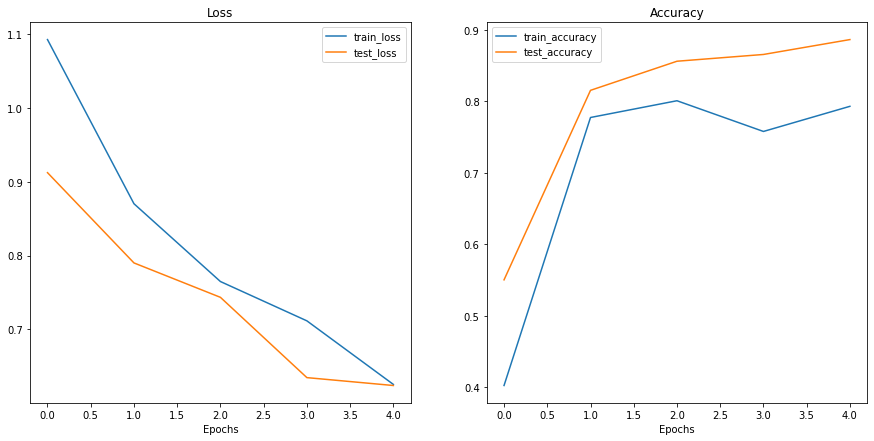

In [35]:
plot_loss_curves(result)

## Make predictions on images from the test set

It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

*Visualize, visualize, visualize!*

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.



In [40]:
from PIL import Image

from torchvision import transforms

def pred_and_plot_image(model:torch.nn.Module,
                        image_path: str,
                        class_names:List[str],
                        image_size:Tuple[int,int]=(224,224),
                        transform:torchvision.transforms=None,
                        device:torch.device=device):
  
  img=Image.open(image_path)
  model.to(device)
  model.eval()

  if transform is not None:
    img_transform=transform
  else:
    img_transform= transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),

                                  ])
  img_transformed=img_transform(img).unsqueeze(dim=0).to(device)
  with torch.inference_mode():
    pred_logits=model(img_transformed)
    pred_class=pred_logits.softmax(axis=1).argmax(axis=1)
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[pred_class]} | Prob: {pred_logits.softmax(axis=1).max().item():.3f}")
  plt.axis(False);


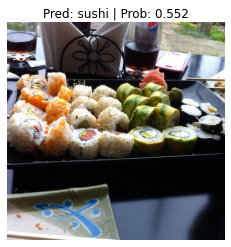

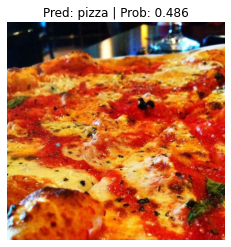

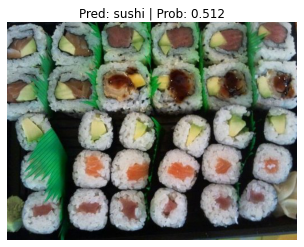

In [41]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))